In [60]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')
 

import os
import gc
import time
import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, mean_squared_error


In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = '../ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fifa_2019' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)



BATCH_SIZE = 64
NOISE = 0.2 
ALPHA = 0.001 
EPOCHS = 30
TEST_SIZE = 0.2

In [63]:
#set the plotting parameters
params = {
    'legend.fontsize': 'medium',
    'figure.figsize':(15,6),
    'axes.labelsize':'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium',
    #'text.usetex':True,
}
plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


$$\text{
    Load Weather Data
}$$

In [64]:
file_loc = 'text_gen\shakespeare.txt'
file_path = os.path.join(inpDir,file_loc)

text = open(file_path, 'rb').read().decode(encoding='utf-8')

text[:100]

'First Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citize'

$$
\text {Character Based Modelling}
$$

In [65]:
vocab = sorted(set(text))

len(vocab)

66

In [66]:
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)

In [67]:
char2idx

{'\n': 0,
 '\r': 1,
 ' ': 2,
 '!': 3,
 '$': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '3': 10,
 ':': 11,
 ';': 12,
 '?': 13,
 'A': 14,
 'B': 15,
 'C': 16,
 'D': 17,
 'E': 18,
 'F': 19,
 'G': 20,
 'H': 21,
 'I': 22,
 'J': 23,
 'K': 24,
 'L': 25,
 'M': 26,
 'N': 27,
 'O': 28,
 'P': 29,
 'Q': 30,
 'R': 31,
 'S': 32,
 'T': 33,
 'U': 34,
 'V': 35,
 'W': 36,
 'X': 37,
 'Y': 38,
 'Z': 39,
 'a': 40,
 'b': 41,
 'c': 42,
 'd': 43,
 'e': 44,
 'f': 45,
 'g': 46,
 'h': 47,
 'i': 48,
 'j': 49,
 'k': 50,
 'l': 51,
 'm': 52,
 'n': 53,
 'o': 54,
 'p': 55,
 'q': 56,
 'r': 57,
 's': 58,
 't': 59,
 'u': 60,
 'v': 61,
 'w': 62,
 'x': 63,
 'y': 64,
 'z': 65}

In [68]:
text_as_int = np.array([char2idx[c] for c in text])
text_as_int.shape

(1155396,)

In [69]:
seq_len = 100
example_per_epoch = len(text) / seq_len+1

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(20):
    print(i.numpy(), end=' : ')
    print(idx2char[i.numpy()])


19 : F
48 : i
57 : r
58 : s
59 : t
2 :  
16 : C
48 : i
59 : t
48 : i
65 : z
44 : e
53 : n
11 : :
1 : 
0 : 

15 : B
44 : e
45 : f
54 : o


In [70]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

for item in sequences.take(2):
    print(item)
    print(repr(''.join(idx2char[item.numpy()])))

tf.Tensor(
[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1  0 15 44 45 54 57 44  2 62
 44  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47
 44 40 57  2 52 44  2 58 55 44 40 50  9  1  0  1  0 14 51 51 11  1  0 32
 55 44 40 50  7  2 58 55 44 40 50  9  1  0  1  0 19 48 57 58 59  2 16 48
 59 48 65 44 53], shape=(101,), dtype=int32)
'First Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citizen'
tf.Tensor(
[11  1  0 38 54 60  2 40 57 44  2 40 51 51  2 57 44 58 54 51 61 44 43  2
 57 40 59 47 44 57  2 59 54  2 43 48 44  2 59 47 40 53  2 59 54  2 45 40
 52 48 58 47 13  1  0  1  0 14 51 51 11  1  0 31 44 58 54 51 61 44 43  9
  2 57 44 58 54 51 61 44 43  9  1  0  1  0 19 48 57 58 59  2 16 48 59 48
 65 44 53 11  1], shape=(101,), dtype=int32)
':\r\nYou are all resolved rather to die than to famish?\r\n\r\nAll:\r\nResolved. resolved.\r\n\r\nFirst Citizen:\r'


In [71]:
def split_intput_target(chunk):
    input_text = chunk[:-1]  # First hundred charater
    target_text = chunk[1:]  # Last character
    return input_text, target_text


dataset = sequences.map(split_intput_target)

for inp_epx, tar_epx in dataset.take(2):
    print(repr(''.join(idx2char[inp_epx.numpy()])))
    print(repr(''.join(idx2char[tar_epx.numpy()])))

'First Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citize'
'irst Citizen:\r\nBefore we proceed any further, hear me speak.\r\n\r\nAll:\r\nSpeak, speak.\r\n\r\nFirst Citizen'
':\r\nYou are all resolved rather to die than to famish?\r\n\r\nAll:\r\nResolved. resolved.\r\n\r\nFirst Citizen:'
'\r\nYou are all resolved rather to die than to famish?\r\n\r\nAll:\r\nResolved. resolved.\r\n\r\nFirst Citizen:\r'


In [72]:
BUFFRE_SIZE = 10000

dataset = dataset.shuffle(BUFFRE_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [73]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [77]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(None,), batch_size=batch_size),
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            kernel_initializer='glorot_uniform',
            recurrent_initializer='orthogonal',
        ),
        tf.keras.layers.Dense(vocab_size)
    ])


In [78]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [79]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (64, None, 256)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (64, None, 1024)       │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, None, 66)         │        67,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for inp_ex, tar_ex in dataset.take(1):
    

SyntaxError: incomplete input (1104047672.py, line 1)

In [ ]:
sample_indices = tf.random.categorical(ex_pred[0], num_samples=1)
print(sample_indices.shape)



In [7]:
num_cols = [
    'Temperature (C)', 
    'Humidity', 
    'Wind Speed (km/h)',
    'Wind Bearing (degrees)', 
    'Visibility (km)', 
    'Pressure (millibars)', 
]

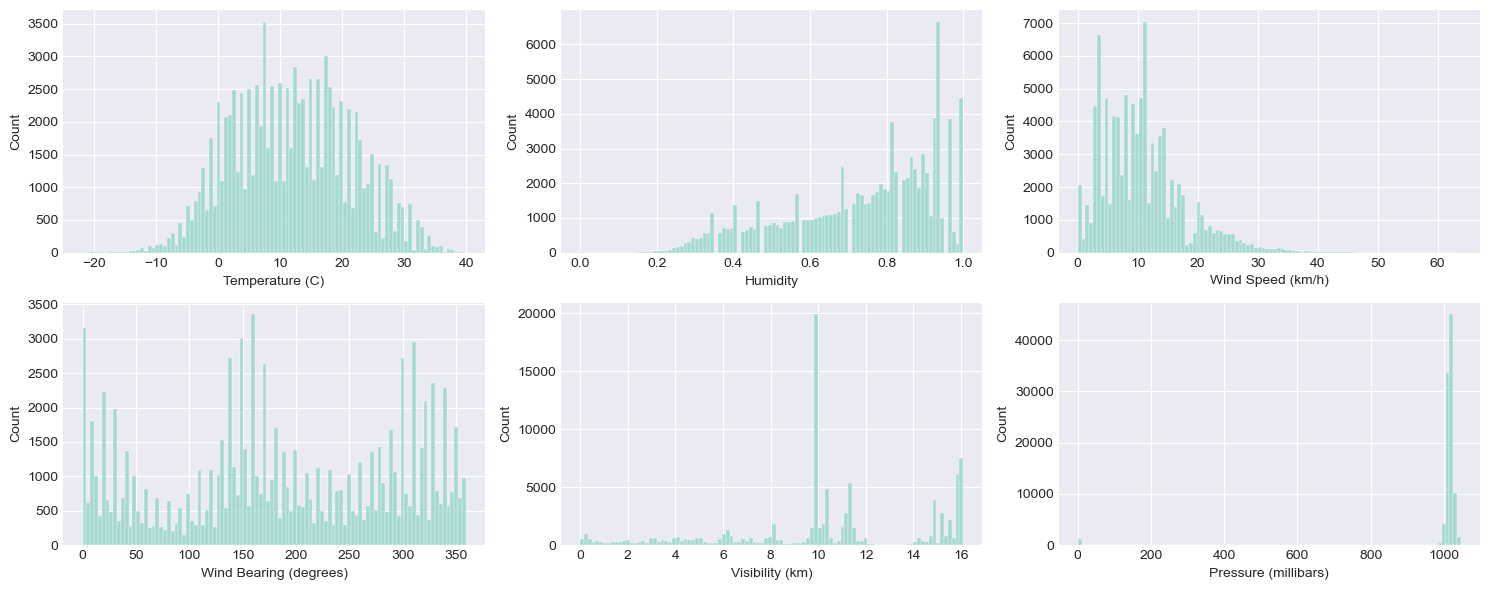

In [8]:
fig, axes = plt.subplots(2,3)

nbin = 100
axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data=data_df, x=col,ax=ax, bins=nbin)

plt.tight_layout()
plt.show()

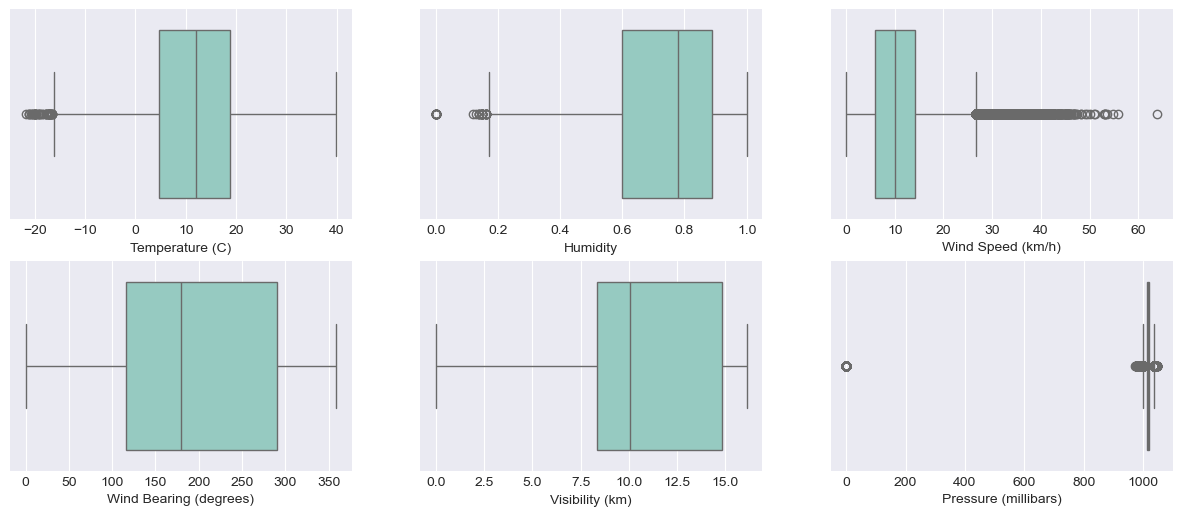

In [9]:
fig, axes = plt.subplots(2,3)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.boxplot(data=data_df, x=col,ax=ax)

plt.show()

<Axes: >

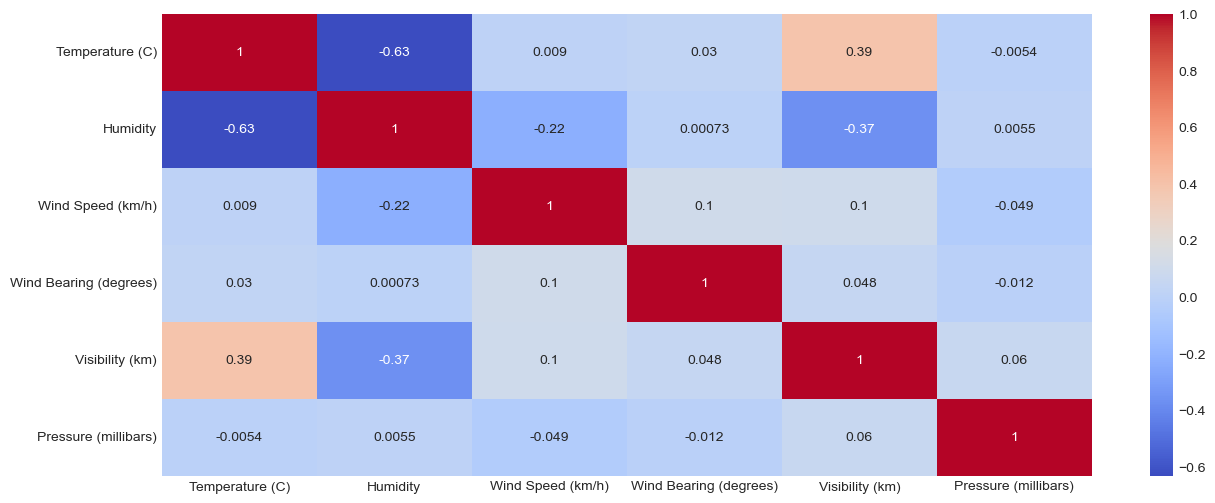

In [10]:
sns.heatmap(data=data_df[num_cols].corr(), annot=True, cmap=CMAP)

In [11]:
data_df['datetime']

0       2006-03-31 22:00:00+00:00
1       2006-03-31 23:00:00+00:00
2       2006-04-01 00:00:00+00:00
3       2006-04-01 01:00:00+00:00
4       2006-04-01 02:00:00+00:00
                   ...           
96448   2016-09-09 17:00:00+00:00
96449   2016-09-09 18:00:00+00:00
96450   2016-09-09 19:00:00+00:00
96451   2016-09-09 20:00:00+00:00
96452   2016-09-09 21:00:00+00:00
Name: datetime, Length: 96453, dtype: datetime64[ns, UTC]

In [12]:
temp_df = data_df[[
    'datetime',
    'Temperature (C)', 
    'Humidity', 
    'Wind Speed (km/h)',
    'Visibility (km)', 
]]

In [13]:
temp_df = temp_df.sort_values(by=['datetime'], axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.rename({
    'Temperature (C)': 'temp',
    'Humidity': 'hum', 
    'Wind Speed (km/h)':'wind',
    'Visibility (km)': 'vis'  
}, axis=1, inplace=True)

temp_df.head()


,datetime,temp,hum,wind,vis
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143,9.9820
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152,9.9015
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538,9.9015
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900,9.9015
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426,9.9015


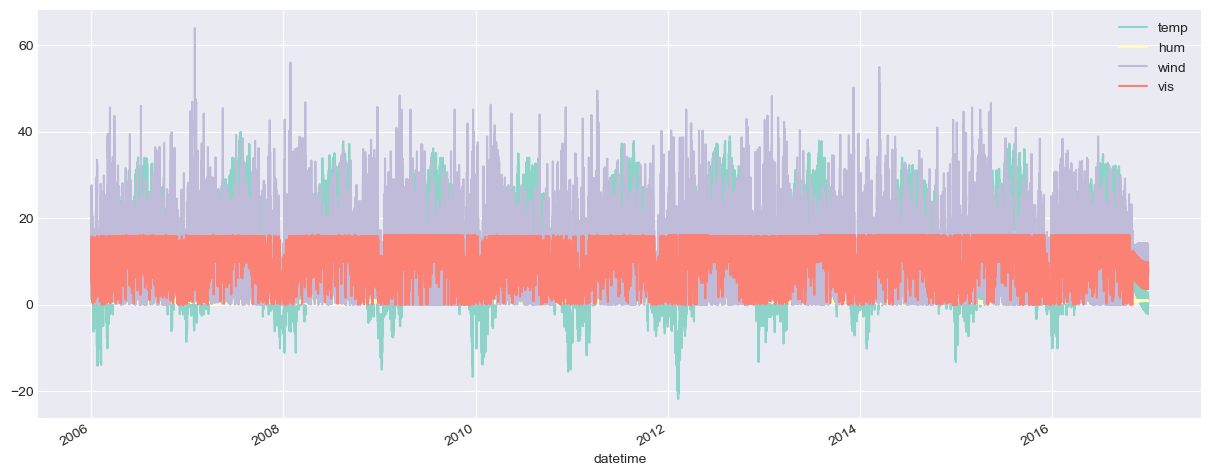

In [14]:
ax = temp_df.plot(x='datetime', y=['temp', 'hum','wind','vis'])

---
$$
\text{Building Actual Model}
$$

In [15]:
time_step = 24
temp_df.shape[0]/time_step

y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx][['datetime', 'temp']]

y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [16]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
display(X_df.shape)
display(y_df.shape)
y_df.head()


(96432, 5)

(4018, 2)

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [17]:
X_temp = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X_hum = np.reshape(X_df['hum'].values, (y_df.shape[0], time_step))
X_wind = np.reshape(X_df['wind'].values, (y_df.shape[0], time_step))
X_vis = np.reshape(X_df['vis'].values, (y_df.shape[0], time_step))

X_temp.shape, y_df.shape

((4018, 24), (4018, 2))

In [18]:
# Remove last Column
X_temp= X_temp[:,:23]
X_hum= X_hum[:,:23]
X_wind= X_wind[:,:23]
X_vis= X_vis[:,:23]

X_temp.shape, X_hum.shape, X_wind.shape, X_vis.shape

((4018, 23), (4018, 23), (4018, 23), (4018, 23))

In [19]:
X_data = np.stack((
    X_temp,
    X_hum,
    X_wind,
    X_vis    
))

X_data.shape

(4, 4018, 23)

```python
format for model

[sample, timesteps, features] 
    |        |          |
  4018      23          4

```

In [20]:
X = np.reshape(X_data, (X_data.shape[1], X_data.shape[2], 4))
X.shape

(4018, 23, 4)

In [21]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
split

3214

In [22]:
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 4), (804, 23, 4), (3214,), (804,))

In [23]:
h_units= 256
input_shape = X_train[0].shape

initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Input(
        shape=input_shape
    )
)

model.add(
    tf.keras.layers.SimpleRNN(
        units=h_units,
        activation='tanh',
        kernel_initializer = initializer
    )
)

model.add(
    tf.keras.layers.Dense(
        1,
        activation='linear',
        kernel_initializer = initializer
    )
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        66,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')


Wax = (4, 256)
Waa = (256, 256)
ba = (256,)
Way = (256, 1)
by = (1,)


In [25]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.RootMeanSquaredError(
        name='RMSE'
    )]
)

In [26]:
history = model.fit(
    x=X_train,
    y=y_train, 
    validation_data = [X_test, y_test],
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - RMSE: 8.3715 - loss: 70.1461 - val_RMSE: 7.0791 - val_loss: 50.1142
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RMSE: 8.0830 - loss: 65.3480 - val_RMSE: 7.0911 - val_loss: 50.2840
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - RMSE: 8.2511 - loss: 68.0897 - val_RMSE: 7.0841 - val_loss: 50.1847
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - RMSE: 8.1366 - loss: 66.2339 - val_RMSE: 7.1782 - val_loss: 51.5262
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - RMSE: 8.0462 - loss: 64.7521 - val_RMSE: 7.3105 - val_loss: 53.4437
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - RMSE: 8.2505 - loss: 68.1353 - val_RMSE: 7.2760 - val_loss: 52.9398
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - RMSE: 8.0427 - loss: 64.6948 - val_RMSE: 7.3534 - val_loss: 54.0730
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - RMSE: 7.9982 - loss: 63.9831 - val_RMSE: 7.3128 - val_loss: 53.4774
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━

In [27]:
hist_df = pd.DataFrame(history.history)

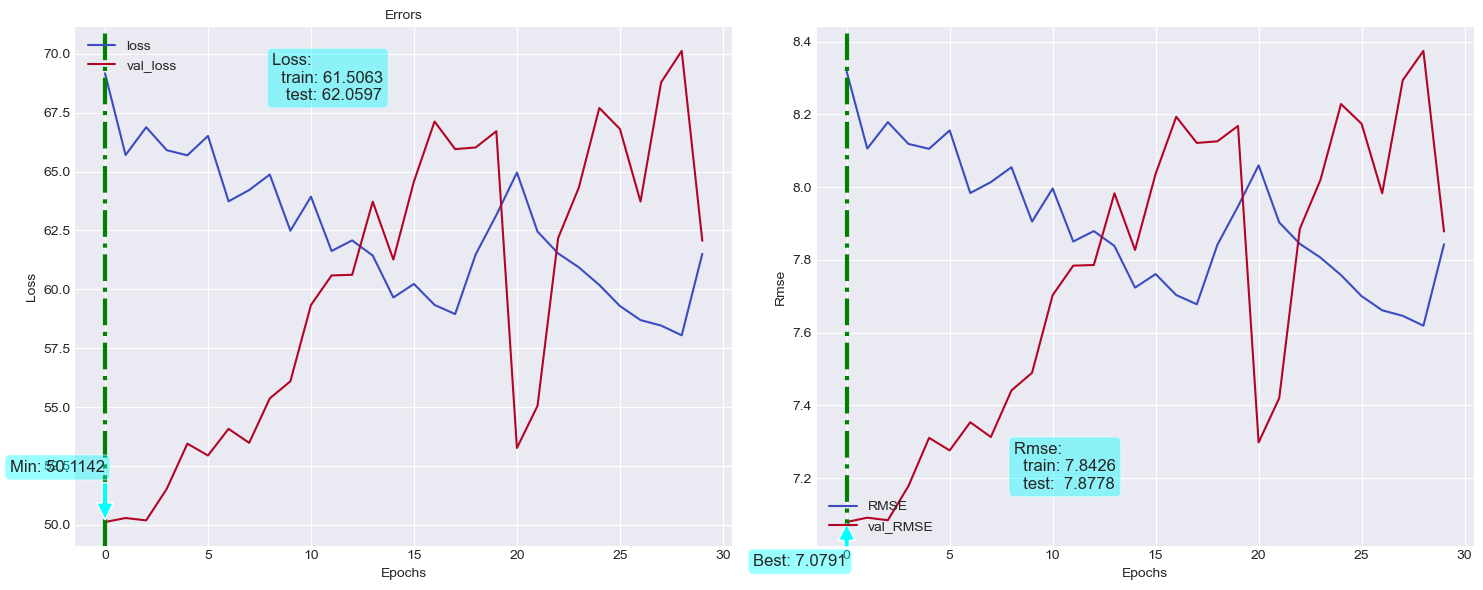

In [28]:
from utils.helper import fn_plot_tf_hist

fn_plot_tf_hist(hist_df)

In [29]:
y_tr_pred = model.predict(X_train)
y_ts_pred = model.predict(X_test)
y_pred = np.append(y_tr_pred,y_ts_pred)


res_df = y_df.copy()
res_df['pred'] = y_pred
res_df


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,9.913353
48,2006-01-02 23:00:00+00:00,1.694444,8.590940
72,2006-01-03 23:00:00+00:00,2.200000,7.648522
96,2006-01-04 23:00:00+00:00,1.666667,-6.691432
120,2006-01-05 23:00:00+00:00,1.805556,4.127687
...,...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778,8.669765
96360,2016-12-28 02:00:00+00:00,-1.677778,8.680061
96384,2016-12-29 02:00:00+00:00,-1.727778,8.685632
96408,2016-12-30 02:00:00+00:00,-1.777778,8.686314


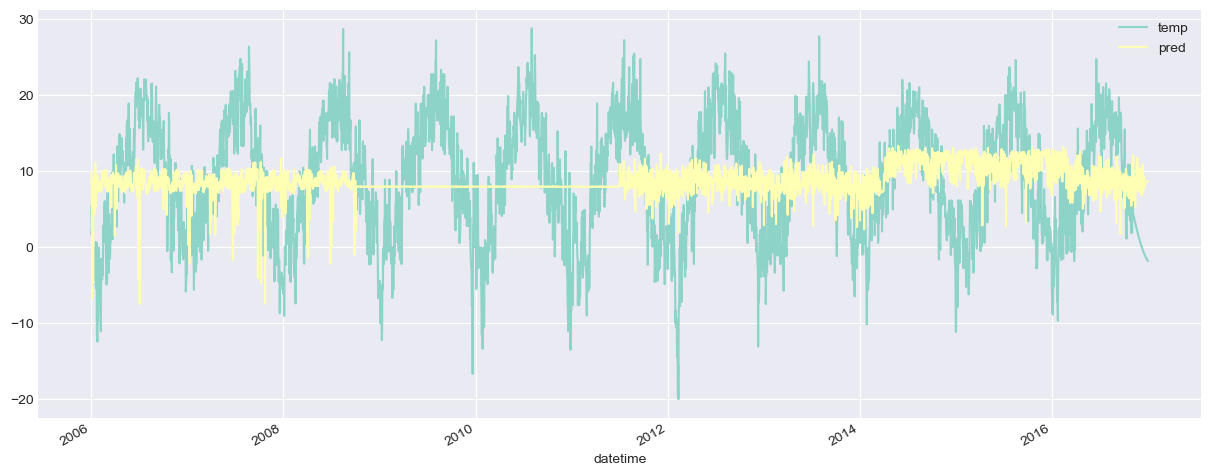

In [30]:
res_df.plot(x='datetime', y=['temp', 'pred'])
plt.show()

In [31]:
print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')


Wax = (4, 256)
Waa = (256, 256)
ba = (256,)
Way = (256, 1)
by = (1,)
